In [2]:
import bento
import decoupler as dc
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import scanpy as sc

# seqFISH+

In [3]:
data = bento.datasets.load_dataset("seqfish_processed")

In [50]:
pattern_df = []
for p in bento._constants.PATTERN_NAMES:
    pdf = data.to_df(p).reset_index().melt(id_vars='cell').groupby("gene").sum()
    pdf['pattern'] = p
    pattern_df.append(pdf)

pattern_df = pd.concat(pattern_df)
pattern_df = pattern_df.reset_index().pivot(index='gene', columns='pattern', values='value')

In [51]:
pattern_counts = pattern_df.T / pattern_df.sum(axis=1)

In [33]:
msigdb = dc.get_resource("MSigDB")

In [34]:
msigdb["collection"].value_counts()

immunesigdb                           936350
go_biological_process                 622739
human_phenotype_ontology              439795
chemical_and_genetic_perturbations    379886
mirna_targets_mirdb                   371613
tf_targets_gtrf                       213799
tf_targets_legacy                     154704
cell_type_signatures                  141785
go_molecular_function                 107215
go_cellular_component                  97282
reactome_pathways                      90674
cancer_modules                         48525
vaccine_response                       43273
cancer_gene_neighborhoods              42422
mirna_targets_legacy                   34147
wikipathways                           31015
oncogenic_signatures                   30214
positional                             20097
kegg_pathways                          12751
pid_pathways                            8078
hallmark                                7346
biocarta_pathways                       4838
Name: coll

In [35]:
msigdb = msigdb[msigdb["collection"] == "kegg_pathways"]
msigdb = msigdb.drop_duplicates(["geneset", "genesymbol"])

In [36]:
msigdb.head()

,genesymbol,collection,geneset
2587,ABCA1,kegg_pathways,KEGG_ABC_TRANSPORTERS
3398,TUBB2A,kegg_pathways,KEGG_GAP_JUNCTION
3659,TUBB2A,kegg_pathways,KEGG_PATHOGENIC_ESCHERICHIA_COLI_INFECTION
3937,BMP2,kegg_pathways,KEGG_CYTOKINE_CYTOKINE_RECEPTOR_INTERACTION
3962,BMP2,kegg_pathways,KEGG_TGF_BETA_SIGNALING_PATHWAY


In [37]:
import mygene

mg = mygene.MyGeneInfo()

query = mg.querymany(
    msigdb["genesymbol"].unique(),
    scopes="symbol,alias,name",
    fields="symbol",
    species="mouse",
)
human2mouse = dict()
for q in query:
    if "symbol" in q:
        human2mouse[q["query"]] = q["symbol"]
    else:
        human2mouse[q["query"]] = q["query"]

[15:44:53] WARNING  563 input query terms found dup hits:   [('ABCA1', 2), ('BMP2', 6), ('SPHK1', 2),   base.py:588
                    ('TNFAIP3', 4), ('TNF', 10), ('TNC', 2), ('MYC', 10), ('SE                                     

           WARNING  341 input query terms found no hit:     ['SERPINA1', 'HLA-C', 'HLA-DMA', 'HLA-A',   base.py:590
                    'HLA-DRB1', 'HLA-G', 'HLA-DQA1', 'FCGR1A', 'CASP5', 'CTSV'                                     

In [38]:
msigdb["geneset_mouse"] = msigdb["genesymbol"].map(human2mouse)

In [39]:
msigdb = msigdb[["geneset", "geneset_mouse"]].drop_duplicates()

In [40]:
out = dc.run_gsea(
    pattern_counts, msigdb, source="geneset", target="geneset_mouse"
)

In [41]:
estimate, norm, pvals = out

In [42]:
norm.head()

source,KEGG_ABC_TRANSPORTERS,KEGG_ACUTE_MYELOID_LEUKEMIA,KEGG_ADHERENS_JUNCTION,KEGG_ADIPOCYTOKINE_SIGNALING_PATHWAY,KEGG_ALANINE_ASPARTATE_AND_GLUTAMATE_METABOLISM,KEGG_ALDOSTERONE_REGULATED_SODIUM_REABSORPTION,KEGG_ALZHEIMERS_DISEASE,KEGG_AMINO_SUGAR_AND_NUCLEOTIDE_SUGAR_METABOLISM,KEGG_AMYOTROPHIC_LATERAL_SCLEROSIS_ALS,KEGG_ANTIGEN_PROCESSING_AND_PRESENTATION,...,KEGG_TYPE_II_DIABETES_MELLITUS,KEGG_T_CELL_RECEPTOR_SIGNALING_PATHWAY,KEGG_UBIQUITIN_MEDIATED_PROTEOLYSIS,KEGG_VALINE_LEUCINE_AND_ISOLEUCINE_DEGRADATION,KEGG_VASCULAR_SMOOTH_MUSCLE_CONTRACTION,KEGG_VASOPRESSIN_REGULATED_WATER_REABSORPTION,KEGG_VEGF_SIGNALING_PATHWAY,KEGG_VIBRIO_CHOLERAE_INFECTION,KEGG_VIRAL_MYOCARDITIS,KEGG_WNT_SIGNALING_PATHWAY
cell_edge,-1.611074,2.049115,1.469740,1.647769,1.848000,1.171134,2.360406,1.985226,1.484105,1.226045,...,0.940024,2.215467,3.159085,2.193353,1.824841,2.159916,1.921842,1.362863,0.904775,2.319935
cytoplasmic,0.691043,1.202591,1.888594,1.362298,1.944301,1.181704,1.184289,1.019822,1.244573,1.279051,...,-0.756006,2.024775,2.476419,0.991099,2.276737,1.587069,2.198526,1.004546,2.126835,1.688661
none,-0.830245,1.226288,0.973850,0.947320,0.663967,0.697582,0.959380,1.133102,0.574045,-0.729021,...,0.690187,2.057047,2.114128,0.930588,1.012046,-1.645375,1.830536,-0.619552,-0.813755,1.855946
nuclear,1.502203,1.509562,2.059248,2.237889,-1.159649,2.080136,2.597116,1.034501,1.312303,1.756910,...,1.879043,1.510322,1.601996,-0.895598,1.583446,1.196609,1.325601,1.905410,1.691354,2.400359
nuclear_edge,1.794041,-0.744091,1.737098,1.298533,-0.902536,1.045498,3.064797,1.135569,0.814278,1.973868,...,1.028933,-1.094149,1.362599,1.517063,1.647607,1.501845,-0.760733,1.775630,1.405235,1.660600


In [43]:
pvals_adj = pd.DataFrame(
    dc.p_adjust_fdr(pvals.values.flatten()).reshape(pvals.shape),
    index=pvals.index,
    columns=pvals.columns,
)

In [46]:
norm_top = []
pval_top = []
for p in bento._constants.PATTERN_NAMES:
    pathways = norm.T.sort_values(p, ascending=False).head(5).index.tolist()
    norm_top.append(norm[pathways])
    pval_top.append(pvals_adj[pathways])

norm_top = pd.concat(norm_top, axis=1)
pval_top = pd.concat(pval_top, axis=1)

pathways_formatted = []
for s in norm_top.columns:
    pathways_formatted.append(
        "_".join([word.capitalize() for word in s.split("_")[1:]])
    )

norm_top.columns = pathways_formatted
pval_top.columns = pathways_formatted

In [47]:
stars = pd.DataFrame(index=pval_top.index, columns=pval_top.columns)
stars[pval_top < 0.1] = '*'
stars[pval_top < 0.01] = '**'
stars[pval_top < 0.001] = '***'

stars = stars.fillna('')

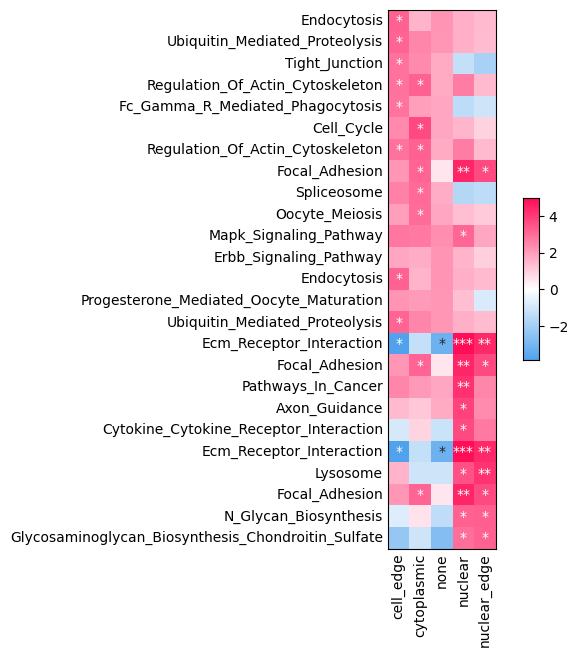

In [48]:
fig = plt.figure(figsize=(7, 7))
ax = sns.heatmap(
    norm_top.T,
    square=True,
    fmt="",
    annot=stars.T,
    cmap=bento.colors.red2blue,
    center=0,
    cbar_kws=dict(shrink=0.3, aspect=10),
)
sns.despine(fig, top=False, right=False)
ax.tick_params(length=0)

rc = {'svg.fonttype': 'none', 'font.family':'Arial'}
with plt.rc_context(rc):
    plt.savefig('/cellar/users/ckmah/spatial/figures/seqfish_lp_top_kegg.svg', dpi=400)

---

# MERFISH

In [55]:
merfish = bento.datasets.load_dataset('merfish_processed')

In [56]:
pattern_df = []
for p in bento._constants.PATTERN_NAMES:
    pdf = merfish.to_df(p).reset_index().melt(id_vars='cell').groupby("gene").sum()
    pdf['pattern'] = p
    pattern_df.append(pdf)

pattern_df = pd.concat(pattern_df)
pattern_df = pattern_df.reset_index().pivot(index='gene', columns='pattern', values='value')

In [57]:
pattern_counts = pattern_df.T / pattern_df.sum(axis=1)

In [59]:
top_patterns = []
for p in bento._constants.PATTERN_NAMES:
    topg = pattern_counts.T.sort_values(p, ascending=False).head(5).index.tolist()
    top_patterns.append(pattern_counts[topg])

top_patterns = pd.concat(top_patterns, axis=1)

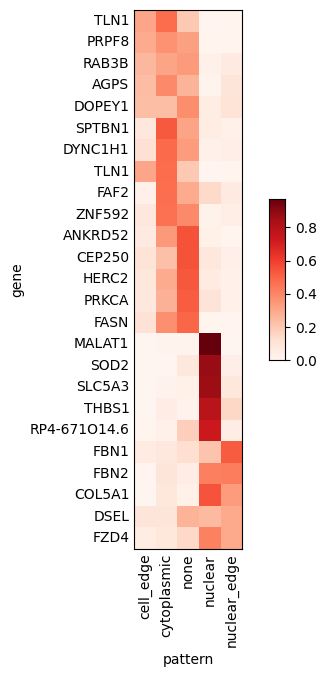

In [60]:
fig = plt.figure(figsize=(7, 7))
ax = sns.heatmap(
    top_patterns.T,
    square=True,
    cmap='Reds',
    cbar_kws=dict(shrink=0.3, aspect=10),
)
sns.despine(fig, top=False, right=False)
ax.tick_params(length=0)

# rc = {'svg.fonttype': 'none', 'font.family':'Arial'}
# with plt.rc_context(rc):
#     plt.savefig('/cellar/users/ckmah/spatial/figures/merfish_lp_top_genes.svg', dpi=400)

In [166]:
merfish.uns['points']

,x,y,gene,cell,nucleus,batch
0,1539.00000,1194.074200,notarget001,31-0,-1,0
1,1020.46277,368.644230,notarget002,15-0,-1,0
2,1469.50900,608.816700,notarget002,16-0,7,0
3,1224.54750,1373.591000,notarget003,28-0,-1,0
4,1541.75090,124.650345,AKAP11,11-0,-1,0
...,...,...,...,...,...,...
16907943,441.81622,666.157960,MALAT1,16-69,8,69
16907944,408.66090,687.625300,MALAT1,16-69,8,69
16907945,430.00000,689.167850,MALAT1,16-69,8,69
16907946,1634.78830,783.617100,MALAT1,23-69,9,69


In [136]:
msigdb = dc.get_resource("MSigDB")

In [137]:
msigdb = msigdb[msigdb["collection"] == "kegg_pathways"]
msigdb = msigdb.drop_duplicates(["geneset", "genesymbol"])

In [147]:
out = dc.run_consensus(
    pattern_counts, msigdb, source="geneset", target="genesymbol", weight=None
)

In [153]:
norm, pvals = out

In [154]:
pvals_adj = pd.DataFrame(
    dc.p_adjust_fdr(pvals.values.flatten()).reshape(pvals.shape),
    index=pvals.index,
    columns=pvals.columns,
)

In [155]:
norm_top = []
pval_top = []
for p in bento.ut.PATTERN_NAMES:
    pathways = norm.T.sort_values(p, ascending=False).head(5).index.tolist()
    norm_top.append(norm[pathways])
    pval_top.append(pvals_adj[pathways])

norm_top = pd.concat(norm_top, axis=1)
pval_top = pd.concat(pval_top, axis=1)

pathways_formatted = []
for s in norm_top.columns:
    pathways_formatted.append(
        "_".join([word.capitalize() for word in s.split("_")[1:]])
    )

norm_top.columns = pathways_formatted
pval_top.columns = pathways_formatted

In [156]:
stars = pd.DataFrame(index=pval_top.index, columns=pval_top.columns)
stars[pval_top < 0.1] = '*'
stars[pval_top < 0.01] = '**'
stars[pval_top < 0.001] = '***'

stars = stars.fillna('')

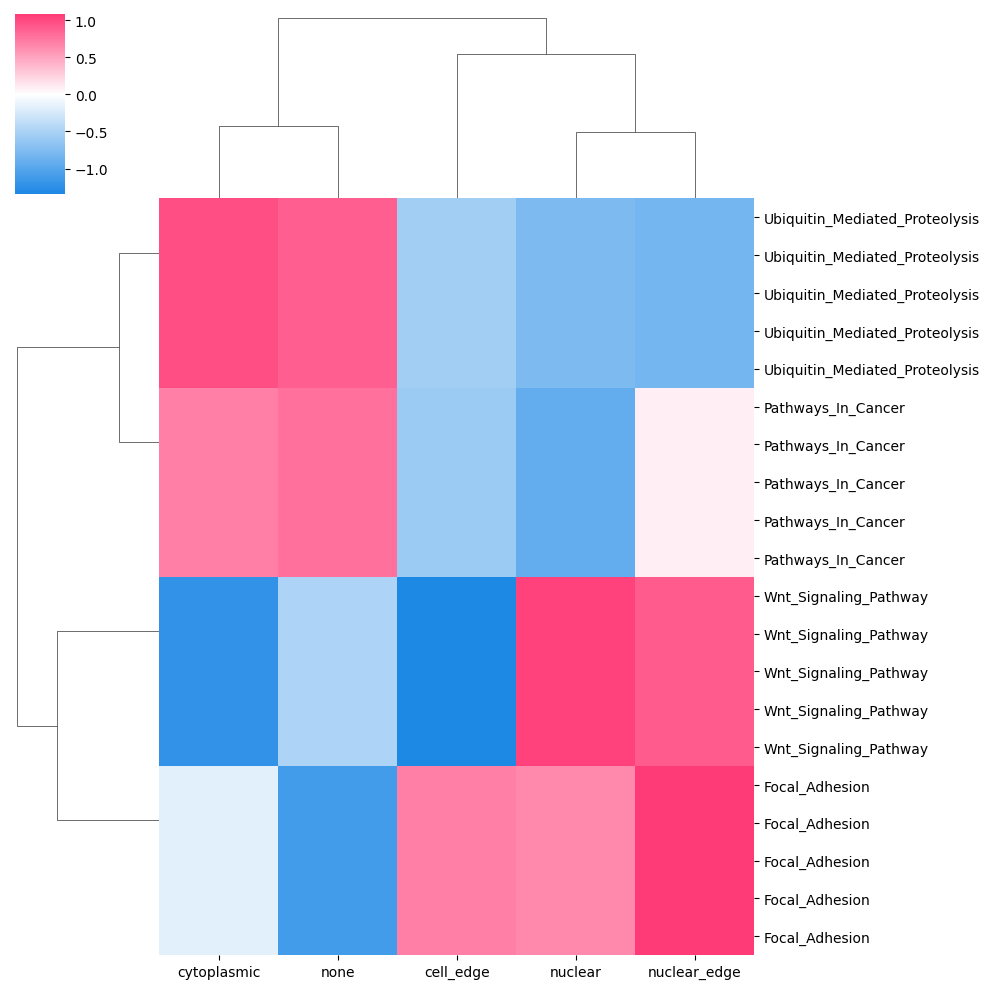

In [167]:
# fig = plt.figure(figsize=(7, 7))
ax = sns.clustermap(
    norm_top.T,
    square=True,
    fmt="",
    annot=stars.T,
    cmap=bento.colors.red2blue,
    center=0,
    cbar_kws=dict(shrink=0.3, aspect=10),
)
# sns.despine(fig, top=False, right=False)
# ax.tick_params(length=0)